In [1]:
from pathlib import Path
import pandas as pd
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this
pd.options.mode.copy_on_write = True        # TESTING THIS...

In [2]:
!ls ~/exp_builds/astera.exp/rundata/run1/6.fighter

6.fighter	     fighter.debug	    locals.csv
6.fighter.debug      fighter.dwarf.sdb	    _raw_debug_locals.csv
6.fighter.debug.sdb  function_params.csv    _raw_dwarf_locals.csv
6.fighter.sdb	     functions.csv	    _raw_stripped_locals.csv
ast_dumps	     ghidra_ast.debug.json
fighter		     ghidra_ast.json


In [3]:
from astlib import StructDatabase
from varlib.datatype import *

bin_folder = Path('/home/cls0027/exp_builds/astera.exp/rundata/run1/6.fighter')
#bin_folder/'_raw_debug_locals.csv'

funcs_df = pd.read_csv(bin_folder/'functions.csv')
locals_df = pd.read_csv(bin_folder/'locals.csv')
sdb = StructDatabase.from_json(bin_folder/'6.fighter.debug.sdb')

# drop COMP variables
locals_df = locals_df.dropna(subset='TypeJson_Debug')
locals_df['Type_Debug'] = locals_df.TypeJson_Debug.apply(DataType.from_json)

In [4]:
sid = sdb.sids_by_name['r_camera'][0]
sdb.structs_by_id[sid]

struct r_camera {
	0x0: float[3] position
	0xc: float[2] size
	0x14: float rotation
	0x18: float[4][4] view
	0x58: float[4][4] projection
	0x98: float near
	0x9c: float far
}

TypeSeq_Debug
ARR,STRUCT         0.773694
PTR,PTR,STRUCT     1.934236
PTR,STRUCT        85.880077
STRUCT            11.411992
Name: FunctionStart, dtype: float64

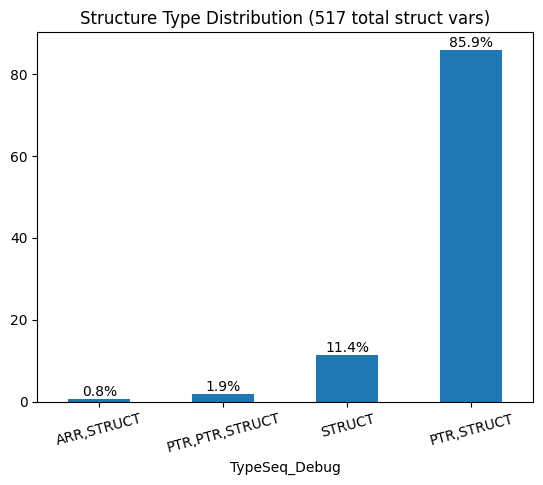

In [5]:
struct_vars = locals_df[locals_df.LeafCategory=='STRUCT']
ax = (struct_vars.groupby('TypeSeq_Debug').count().FunctionStart/len(struct_vars)*100).sort_values().plot(kind='bar',rot=15,
    title=f'Structure Type Distribution ({len(struct_vars):,} total struct vars)'
)

ax.bar_label(ax.containers[0], fmt='{:.1f}%')
struct_vars.groupby('TypeSeq_Debug').count().FunctionStart/len(struct_vars)*100

# Recover Offsets for PTR,STRUCT Variables
Try recovering STRUCT* offsets:

1. Retype variable to `char*`
2. Collect member offsets for this variable from AST (don't forget about implicit 0 offset)
3. Compare with truth (flattened structure layout)


In [6]:
struct_ptrs = struct_vars[struct_vars.TypeSeq_Debug=='PTR,STRUCT']
ghidra_acc = (struct_ptrs.TypeSeq_Strip==struct_ptrs.TypeSeq_Debug).sum()/len(struct_ptrs)*100
print(f'BTW - Ghidra accuracy on STRUCT* types: {ghidra_acc:.2f}%')

BTW - Ghidra accuracy on STRUCT* types: 6.08%


In [7]:
var_row = struct_ptrs.iloc[0]

stype = var_row.Type_Debug.leaf_type
print(stype)
stype = sdb.structs_by_id[stype.sid]    # lookup full definition
stype

asset_t


struct asset_t {
	0x0: uint32 uid
	0x8: uchar* data
	0x10: uint32 data_length
	0x18: char* name
	0x20: int32 chunk_start
	0x24: int32 chunk_length
	0x28: uchar fs
	0x29: uchar filled
	0x2a: uchar req
	0x2b: uchar req_free
	0x2c: uchar chunk
}

In [8]:
truth_offsets = list(stype.layout.keys())
truth_offsets

[0, 8, 16, 24, 32, 36, 40, 41, 42, 43, 44]

In [9]:
var_row

FunctionStart                     1090825
Signature                        27,64,89
Name_Strip                          lVar2
Type_Strip                          int64
LocType_Strip                    register
LocRegName_Strip                      rax
LocOffset_Strip                         0
TypeCategory_Strip                BUILTIN
TypeSeq_Strip                       int64
Name_Debug                          asset
Type_Debug                       asset_t*
LocType_Debug                    register
LocRegName_Debug                      rax
LocOffset_Debug                       0.0
TypeCategory_Debug                    PTR
TypeSeq_Debug                  PTR,STRUCT
HasDWARF                            False
TypeJson_Debug        {"kind": "Pointe...
LeafCategory                       STRUCT
LeafSigned                          False
LeafFloating                        False
LeafSize                                0
PtrLevels                             PLL
PtrL1                             

In [10]:
pchar_t = PointerType(BuiltinType.from_standard_name('char'), 8)
pchar_t

char*

In [11]:
import pyhidra; pyhidra.start()
from ghidralib.projects import *
from ghidralib.ghidraretyper import GhidraRetyper

#with OpenSharedGhidraProject('localhost', 'astera') as proj:
osgp = OpenSharedGhidraProject('localhost', 'astera')
proj = osgp.__enter__()

fighter_strip = locate_binaries_from_project(proj, ['fighter'], strip_only=True)[0]
verify_ghidra_revision(fighter_strip, 1, rollback_delete=True)

#with GhidraCheckoutProgram(proj, fighter_strip) as co:
gcp = GhidraCheckoutProgram(proj, fighter_strip)
co = gcp.__enter__()

6.fighter @ version 2 does not match expected version 1
Rolling back 6.fighter from version 2 to version 1...


In [12]:
func = [f for f in co.decompiler.functions if f.entryPoint.offset == var_row.FunctionStart][0]
print(func)

ast = co.decompiler.decompile_ast(func)
high_sym = co.decompiler.local_sym_dict[var_row.Name_Strip]
print(high_sym)

retyper = GhidraRetyper(co.program, sdb=None)
retyper.set_funcvar_type(high_sym, pchar_t, 'var1')

FUN_0010a509
ghidra.program.model.pcode.HighSymbol@3013e1e8


In [13]:
ast = co.decompiler.decompile_ast(func)
ast

In [14]:
[x.inner for x in ast.inner[-1].inner[-1].inner[:3]]

[[uint32 uVar1 @ LocType=register,Reg=eax,Off=0],
 [char* var1 @ LocType=register,Reg=rax,Off=0],
 [int64 lVar2 @ LocType=register,Reg=rax,Off=0]]

In [46]:
# TODO: probably want to write a custom visitor eventually...
from astlib import FindAllVarRefs, VisitAllChildrenByDefaultVisitor
from astlib.ast import *

refs = FindAllVarRefs('var1').visit(ast)
refs

[<DeclRef: var1>, <DeclRef: var1>, <DeclRef: var1>]

In [67]:
debug_ast_jsonfile = funcs_df[(funcs_df.FunctionStart==var_row.FunctionStart)&(funcs_df.BinaryId==var_row.BinaryId)].iloc[0].AstJson_Debug
debug_ast = read_json(debug_ast_jsonfile, sdb)
debug_ast

In [68]:
class CollectStructMemberRefs(VisitAllChildrenByDefaultVisitor):
    def __init__(self):
        '''
        ast: The AST to search for MemberExpr nodes
        '''
        super().__init__()
        # self.member_exprs:List[MemberExpr] = []

    def visit_MemberExpr(self, memexpr:MemberExpr):
        # self.member_exprs.append(memexpr)
        return memexpr

# check debug AST for member expressions
memberexprs = CollectStructMemberRefs().visit(debug_ast)
memberexprs

[<DeclRef: asset>->data (offset=0x8, sid=72057594037927950),
 <DeclRef: asset_00>->data (offset=0x8, sid=72057594037927950)]

In [88]:
var_row.Name_Debug
memberexprs[0]#.inner[0].referencedDecl.name

<DeclRef: asset>->data (offset=0x8, sid=72057594037927950)

In [16]:
candidates = []
for x in refs:
    x:ASTNode
    if isinstance(x.parent, BinaryOperator):
        binop = x.parent
        if binop.opcode == '+':
            candidates.append(binop)

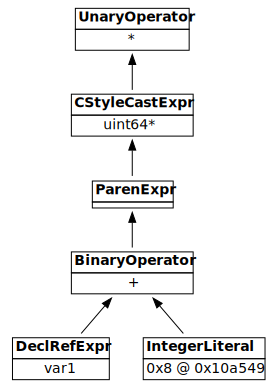

In [57]:
refs[1].parent.parent.parent.parent.render()

In [25]:
recovered_offsets = []
recovered_offsets.extend(filter(lambda x: isinstance(x, IntegerLiteral), candidates[0].inner))

In [32]:
for x in recovered_offsets:
    print(f'Recovered offset 0x{x.value:x} @ 0x{x.instr_addr:x}')

Recovered offset 0x8 @ 0x10a549


In [36]:
stype.layout

0x0: uint32 uid
0x8: uchar* data
0x10: uint32 data_length
0x18: char* name
0x20: int32 chunk_start
0x24: int32 chunk_length
0x28: uchar fs
0x29: uchar filled
0x2a: uchar req
0x2b: uchar req_free
0x2c: uchar chunk

In [40]:
gcp.__exit__(None, None, None)
osgp.__exit__(None, None, None)

PROGRAM CHANGED - CHECKING IN
